<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/LSTMEnergyModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [4]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

In [5]:
n_features = 1
n_steps = 6

In [6]:
filename = '/content/drive/Shared drives/CMPE295B/JoinedPGEBulbData/2021-09-07_21_2021-10-19_18_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [7]:
bulb_data.head()

,timestamp,brightness,kelvin,kWH,cost,usage,percent_usage_by_bulb,cost_per_bulb
0,2021-09-07 21:00:00,0.961538,2596.153846,0.0085,0.07,0.21,4.047619,0.002833
1,2021-09-07 22:00:00,0.700000,1890.000000,0.0085,0.35,1.29,0.658915,0.002306
2,2021-09-07 23:00:00,0.000000,0.000000,0.0000,0.35,1.31,0.000000,0.000000
3,2021-09-08 00:00:00,0.000000,0.000000,0.0000,0.14,0.54,0.000000,0.000000
4,2021-09-08 01:00:00,0.000000,0.000000,0.0000,0.08,0.35,0.000000,0.000000


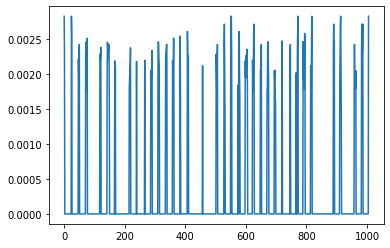

In [8]:
plt.plot(bulb_data['cost_per_bulb'])

In [23]:
def split_train_test(df, split):
  values = df.values
  size = int(len(values) * split)
  train = values[:size]
  test = values[size:]
  return (train, test)

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)

	return np.array(X), np.array(y)

In [24]:
n_steps = 4
train, test = split_train_test(bulb_data[['cost_per_bulb']], 0.9)
print (len(train), len(test))
X_train, y_train = split_sequence(train, n_steps)

905 101


In [12]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.fit(X_train, y_train, epochs=200, verbose=0)

In [15]:
X_test, y_test = split_sequence(test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [16]:
yhat = model.predict(X_test, verbose=0)

In [17]:
rmse = sqrt(mean_squared_error(y_test, yhat))
print (rmse)

0.0010566065626573125


In [18]:
def plot_preds(test, predictions):
  plt.title('Hourly lighting cost predictions')
  plt.xlabel('Timestep')
  plt.ylabel('Cost in Dollars')
  plt.plot(test)
  plt.plot(predictions, color='red')
  plt.show()

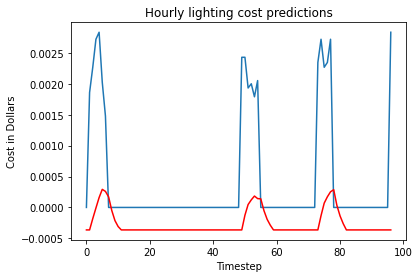

In [19]:
plot_preds(y_test, yhat)

In [20]:
filename = '/content/drive/Shared drives/CMPE295B/ProcessedPGEData/pge_data_from_influx_2020-10-10-20_30_2021-10-01-00_00.csv'
pge_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
pge_data['timestamp'] = pd.to_datetime(pge_data['timestamp'])

In [33]:
n_steps = 7
train, test = split_train_test(pge_data[['cost']], 0.8)
print (len(train), len(test))
X_train, y_train = split_sequence(train, n_steps)

27272 6819


In [34]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [35]:
model.fit(X_train, y_train, epochs=200, verbose=0)

In [36]:
X_test, y_test = split_sequence(test, n_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [37]:
yhat = model.predict(X_test, verbose=0)

In [38]:
rmse = sqrt(mean_squared_error(y_test, yhat))
print (rmse)

0.005827963317143971


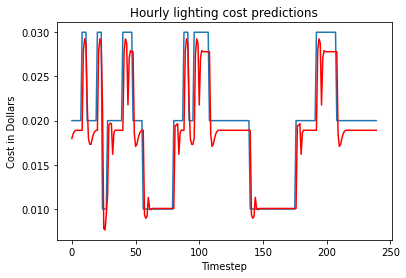

In [43]:
plot_preds(y_test[-240:], yhat[-240:])